# ECE176 Final Project

In [10]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import json
import seaborn as sns
from mido import MidiFile, tick2second
from data_processing.tokenize_midi import tokenize_basic_vocab
from data_processing.decoding import decode_to_tokens_basic_vocab

## Dataset

In [11]:
import torch
print(torch.__version__)          # Should show a version with CUDA (not CPU)
print(torch.cuda.is_available())  # Should return True
print(torch.version.cuda)         # Should match your CUDA version

if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(device)
    gpu_capability = torch.cuda.get_device_capability(device)
    total_memory = torch.cuda.get_device_properties(device).total_memory / 1e9  # Convert to GB

    print(f"GPU Name: {gpu_name}")
    print(f"Compute Capability: {gpu_capability}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    print("CUDA device not available.")

2.6.0
False
None
CUDA device not available.


['NOTE_ON_37', 'VELOCITY_22', 'TIME_SHIFT_20ms', 'NOTE_OFF_37', 'TIME_SHIFT_460ms', 'TIME_SHIFT_10ms', 'NOTE_ON_37', 'VELOCITY_22', 'TIME_SHIFT_20ms', 'NOTE_OFF_37', 'TIME_SHIFT_460ms', 'TIME_SHIFT_10ms', 'NOTE_ON_37', 'VELOCITY_22', 'TIME_SHIFT_20ms', 'NOTE_OFF_37', 'TIME_SHIFT_460ms', 'TIME_SHIFT_10ms', 'NOTE_ON_37', 'VELOCITY_23', 'TIME_SHIFT_20ms', 'NOTE_OFF_37', 'TIME_SHIFT_460ms', 'TIME_SHIFT_10ms', 'NOTE_ON_52', 'VELOCITY_23', 'NOTE_ON_42', 'VELOCITY_22', 'NOTE_ON_52', 'VELOCITY_27', 'NOTE_ON_52', 'VELOCITY_27', 'TIME_SHIFT_20ms', 'NOTE_OFF_42', 'TIME_SHIFT_220ms', 'NOTE_ON_62', 'VELOCITY_26', 'NOTE_ON_62', 'VELOCITY_26', 'TIME_SHIFT_40ms', 'NOTE_ON_62', 'VELOCITY_24', 'TIME_SHIFT_200ms', 'NOTE_ON_42', 'VELOCITY_22', 'TIME_SHIFT_20ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_42', 'TIME_SHIFT_200ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_62', 'NOTE_ON_54', 'VELOCITY_23', 'NOTE_ON_54', 'VELOCITY_23', 'NOTE_ON_54', 'VELOCITY_23', 'TIME_SHIFT_10ms', 'NOTE_OFF_52', 'NOTE_ON_61', 'VELOCITY_31', 'NOTE_ON_

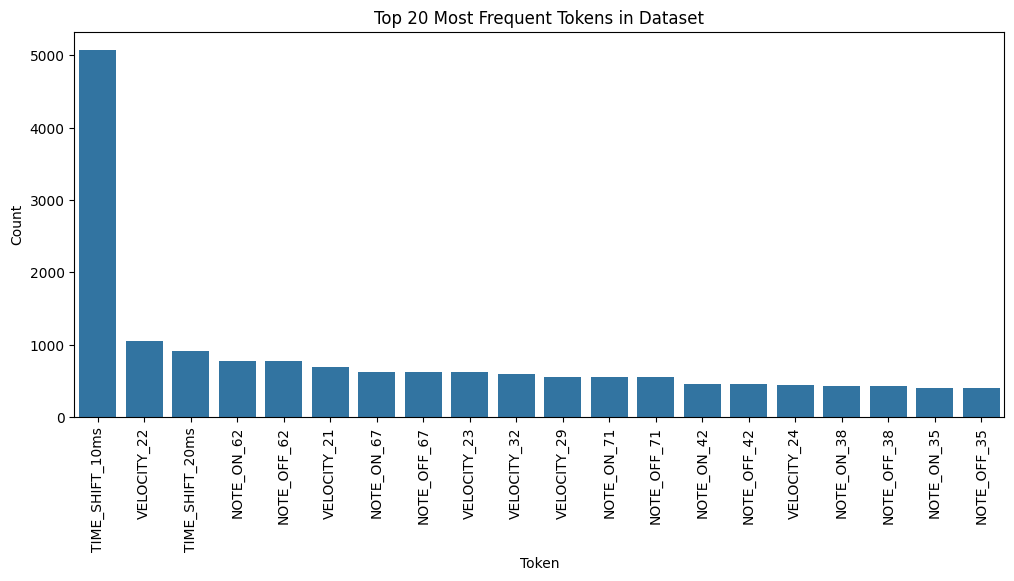

timeshifts: 7764
velocities: 6061
notes: 12122
MIDI file saved to ./decoded.mid


In [70]:
from data_processing.tokenize_midi import tokenize_basic_vocab
from data_processing.decoding import decode_to_tokens_basic_vocab
import importlib
import data_processing.tokenize_midi
from data_processing.decoding import decode_to_midi_basic_vocab
import data_processing.decoding

importlib.reload(data_processing.tokenize_midi)
importlib.reload(data_processing.decoding)


from data_processing.tokenize_midi import tokenize_basic_vocab


file1 = "datasets/raw_midi/lmd_full_direct/c0a7b59ac24b8e0dbc4df9a61cee7e11.mid"
file2 = "datasets/raw_midi/lmd_full_direct/c0ae1d2daacff3fe4549aac56f12485f.mid"

mid = MidiFile(file1)
id_sequence = tokenize_basic_vocab(mid)
token_sequence = decode_to_tokens_basic_vocab(id_sequence)
print(token_sequence)

from collections import Counter

# Count token occurrences
token_counts = Counter(token_sequence)

# Convert to token names
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 20 tokens
print("Top 20 Most Frequent Tokens:")
for token, count in sorted_tokens[:20]:
    print(f"{token}: {count}")

# Bar plot of most common tokens
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_tokens[:20]], y=[t[1] for t in sorted_tokens[:20]])
plt.xticks(rotation=90)
plt.xlabel("Token")
plt.ylabel("Count")
plt.title("Top 20 Most Frequent Tokens in Dataset")
plt.show()

timeshifts = 0
velocities = 0
notes = 0
for token in token_counts:
    if "TIME" in token:
        timeshifts += token_counts[token]
    if "VELOCITY" in token:
        velocities += token_counts[token]
    if "NOTE" in token:
        notes += token_counts[token]

print(f"timeshifts: {timeshifts}")
print(f"velocities: {velocities}")
print(f"notes: {notes}")

decode_to_midi_basic_vocab(token_sequence, "./decoded.mid")



In [ ]:
# Paths
TRAIN_DATA_PATH = "datasets/tokenized/train"
VOCAB_PATH = "datasets/vocab/basic_vocab.json"

# Load vocabulary
with open(VOCAB_PATH, "r") as f:
    vocab = json.load(f)

# Reverse vocab (ID -> Token)
id_to_token = {v: k for k, v in vocab.items()}

# Load tokenized sequences
def load_all_sequences(data_path, max_files=1000):
    """Loads all tokenized sequences from the specified dataset path."""
    sequences = []
    files = sorted(os.listdir(data_path))[:max_files]  # Limit for performance
    for file in files:
        if file.endswith(".pkl"):
            with open(os.path.join(data_path, file), "rb") as f:
                seq = pickle.load(f)
                if len(seq) == 0:
                    print(file)
                sequences.append(seq)
    return sequences

train_sequences = load_all_sequences(TRAIN_DATA_PATH)
print(f"Loaded {len(train_sequences)} tokenized sequences from {TRAIN_DATA_PATH}")

In [ ]:
def ids_to_tokens(vocab, id_sequence):
    # Reverse the vocab (ID -> Token)
    id_to_token = {v: k for k, v in vocab.items()}

    # Convert token IDs back to tokens
    token_sequence = [id_to_token.get(token_id, "<UNK>") for token_id in id_sequence]

    return token_sequence

id_sequence = train_sequences[1]  # Example sequence of token IDs
tokens = ids_to_tokens(vocab, id_sequence)

print(len(tokens))
print("Decoded Tokens:", tokens)


In [ ]:
seq_lengths = []
num_zero_len = 0
for seq in train_sequences:
    seq_lengths.append(len(seq))
    if len(seq) == 0:
        num_zero_len += 1

# Statistics
print(f"Min Length: {np.min(seq_lengths)}")
print(f"Max Length: {np.max(seq_lengths)}")
print(f"Mean Length: {np.mean(seq_lengths):.2f}")
print(f"Median Length: {np.median(seq_lengths)}")
print(f"Number of zero lenght sequences: {num_zero_len}")

# Histogram of sequence lengths
plt.figure(figsize=(10, 5))
sns.histplot(seq_lengths, bins=50, kde=True)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Sequence Lengths")
plt.show()


In [ ]:
from collections import Counter

# Flatten sequences into a single list of token IDs
all_tokens = [token for seq in train_sequences for token in seq]

# Count token occurrences
token_counts = Counter(all_tokens)

# Convert to token names
token_names = {id_to_token[k]: v for k, v in token_counts.items()}
sorted_tokens = sorted(token_names.items(), key=lambda x: x[1], reverse=True)

# Display top 20 tokens
print("Top 20 Most Frequent Tokens:")
for token, count in sorted_tokens[:20]:
    print(f"{token}: {count}")

# Bar plot of most common tokens
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_tokens[:20]], y=[t[1] for t in sorted_tokens[:20]])
plt.xticks(rotation=90)
plt.xlabel("Token")
plt.ylabel("Count")
plt.title("Top 20 Most Frequent Tokens in Dataset")
plt.show()


In [ ]:
# Extract all TIME_SHIFT tokens
time_shift_tokens = [id_to_token[token] for token in all_tokens if "TIME_SHIFT" in id_to_token[token]]

# Count occurrences of each TIME_SHIFT value
time_shift_counts = Counter(time_shift_tokens)
sorted_shifts = sorted(time_shift_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 15 time shifts
print("Top 15 Most Frequent TIME_SHIFT Tokens:")
for shift, count in sorted_shifts[:15]:
    print(f"{shift}: {count}")

# Plot distribution of TIME_SHIFT tokens
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_shifts[:15]], y=[t[1] for t in sorted_shifts[:15]])
plt.xticks(rotation=90)
plt.xlabel("Time Shift Token")
plt.ylabel("Count")
plt.title("Most Frequent TIME_SHIFT Tokens")
plt.show()


In [ ]:
# Extract all VELOCITY tokens
velocity_tokens = [id_to_token[token] for token in all_tokens if "NOTE_OFF" in id_to_token[token]]

# Count occurrences
velocity_counts = Counter(velocity_tokens)
sorted_velocities = sorted(velocity_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 10 velocities
print("Top 10 Most Frequent VELOCITY Tokens:")
for vel, count in sorted_velocities[:10]:
    print(f"{vel}: {count}")

# Plot velocity distribution
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_velocities[:10]], y=[t[1] for t in sorted_velocities[:10]])
plt.xticks(rotation=90)
plt.xlabel("Velocity Token")
plt.ylabel("Count")
plt.title("Most Frequent VELOCITY Tokens")
plt.show()


In [ ]:
def count_initial_time_shifts(sequences, id_to_token):
    time_shift_counts = []
    for seq in sequences:
        count = 0
        for token_id in seq:
            token = id_to_token.get(token_id, "")
            if token.startswith("TIME_SHIFT_"):
                count += 1
            else:
                break  # Stop counting once a non-time-shift token is encountered
        time_shift_counts.append(count)
    return time_shift_counts

def count_ending_time_shifts(sequences, id_to_token):
    time_shift_counts = []
    for seq in sequences:
        count = 0
        for token_id in reversed(seq):  # Iterate from the end
            token = id_to_token.get(token_id, "")
            if token.startswith("TIME_SHIFT_"):
                count += 1
            else:
                break  # Stop counting once a non-time-shift token is encountered
        time_shift_counts.append(count)
    return time_shift_counts

initial_time_shifts = count_initial_time_shifts(train_sequences, id_to_token)
print(f"🔹 Average initial TIME_SHIFT tokens: {np.mean(initial_time_shifts):.2f}")

ending_time_shifts = count_ending_time_shifts(train_sequences, id_to_token)
print(f"🔹 Average ending TIME_SHIFT tokens: {np.mean(ending_time_shifts):.2f}")


plt.figure(figsize=(10, 5))
sns.histplot(initial_time_shifts, bins=300, kde=True)
plt.xlabel("Number of Initial TIME_SHIFT Tokens")
plt.ylabel("Count")
plt.title("Distribution of Initial TIME_SHIFT Tokens in Training Sequences")
plt.show()


In [ ]:
import numpy as np

# Function to compute the proportion of initial TIME_SHIFT tokens per sequence
def compute_time_shift_proportions(sequences, id_to_token):
    proportions = []
    
    for seq in sequences:
        total_length = len(seq)
        time_shift_count = 0

        # Count initial TIME_SHIFT tokens
        for token_id in seq:
            token = id_to_token.get(token_id, "")
            if token.startswith("TIME_SHIFT_"):
                time_shift_count += 1
            else:
                break  # Stop once a non-TIME_SHIFT token is encountered

        # Compute proportion of silence in the song
        proportion = time_shift_count / total_length if total_length > 0 else 0
        proportions.append(proportion)

    return proportions

# Compute proportions for training data
time_shift_proportions = compute_time_shift_proportions(train_sequences, id_to_token)

# Display basic statistics
print(f"🔹 Average Silence Proportion: {np.mean(time_shift_proportions):.2%}")
print(f"🔹 Median Silence Proportion: {np.median(time_shift_proportions):.2%}")
print(f"🔹 Max Silence Proportion: {np.max(time_shift_proportions):.2%}")
print(f"🔹 Min Silence Proportion: {np.min(time_shift_proportions):.2%}")

In [ ]:
silent_endings = sum(1 for count in ending_time_shifts if count > 30)  # Threshold for excessive silence
total_sequences = len(ending_time_shifts)

print(f"🔹 Sequences with >50 Ending TIME_SHIFT Tokens: {silent_endings}/{total_sequences} ({silent_endings / total_sequences * 100:.2f}%)")
